In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [2]:
class galerkin_bim:
    def __init__(self, n, a, b, lam, x1, x2, rhs):
        
        '''
        to use this class, need to define an instance with the above inputs
        then call the function construct_greens_function to initialize the kernel
        then call build_linear_system to assemble the linear system
        then finally call solve_mu to solve the linear system for mu
        
        the function get_t_values returns the computational grid
        the function get_trap_weights returns the weights for composite trapezoid rule
        '''
        
        self.n = n
        self.a = a
        self.b = b
        self.lam = lam
        
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        
        self.x1 = x1.subs(q,self.s)
        self.x2 = x2.subs(q,self.s)
        self.y1 = x1.subs(q,self.t)
        self.y2 = x2.subs(q,self.t)
        
        # initialize h for quadrature to find u
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n+1,n+1))
        self.rhs_values = np.zeros(n+1)
        self.mu = np.zeros(n+1)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
    
    
    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to composite trapezoid nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in + 1):
            t_values[i] = self.a + i*h_in
        
        return t_values
    
    
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;
        
        return weights
        
        
    def construct_greens_function(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)

        # normal vector in 2D
        self.normal = (1/self.jacobian) * sp.Array([-1*sp.diff(self.y2,self.t),sp.diff(self.y1,self.t)])

        # greens function and normal derivative of greens function
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
        self.del_greens_fxn = sp.Array([-1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x1-self.y1),
                                        -1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x2-self.y2)])
        self.dgreens_dn = self.del_greens_fxn[0] * self.normal[0] + self.del_greens_fxn[1] * self.normal[1]
        self.dgreens_dn_simplified = sp.simplify(self.dgreens_dn)
        self.dgreens_dn_lam = sp.lambdify([self.t,self.s],self.dgreens_dn_simplified)
        # order for inputs is (t,s)
        # integration variable t
        # evaulation point s (on boundary)

        # for the case where the kernel is nearly singular (not used here)
        self.kappa = (-1/(4*np.pi))*(sp.diff(self.y2,self.t,self.t)*sp.diff(self.y1,self.t)-sp.diff(self.y1,self.t,self.t)*sp.diff(self.y2,self.t))*(1/(sp.Pow(sp.diff(self.y1,self.t),2)+sp.Pow(sp.diff(self.y2,self.t),2)))
        self.kappa_lam = sp.lambdify(self.t,self.kappa)
        
        
    def build_linear_system(self):
        # build matrix and rhs of the linear system
        
        # define the grid (later used to compute u with trapezoid rule)
        t_values = self.get_t_values(self.n)
        
        # quadrature nodes and weights for 3 point Gauss-Legendre quadrature
        xii = np.array([0.7745966692414834, 0, -0.7745966692414834]);
        wi = np.array([0.5555555555555556, 0.8888888888888888, 0.5555555555555556]);
        
        # two basis functions on [-1,1]
        phi1 = lambda x: 0.5 * (1 - x)
        phi2 = lambda x: 0.5 * (1 + x)
        
        # first build the rhs
        # this is the function y defined symbolically
        self.y_lam = sp.lambdify(self.t,self.rhs)
        
        # stores the two different integrals for each part of l
        y1_ints = np.zeros(self.n)
        y2_ints = np.zeros(self.n)
        
        # stores the rhs of linear system
        rhs_vec = np.zeros(self.n + 1)
        
        for i in range(1, self.n + 1):
            xirhs = lambda x: t_values[i-1] * 0.5 * (1 - x) + t_values[i] * 0.5 * (1 + x)
            y1_intgrnd_0 = ( self.y_lam(xirhs(xii[0])) * phi1(xii[0]) * 0.5 * self.h ) * wi[0]
            y1_intgrnd_1 = ( self.y_lam(xirhs(xii[1])) * phi1(xii[1]) * 0.5 * self.h ) * wi[1]
            y1_intgrnd_2 = ( self.y_lam(xirhs(xii[2])) * phi1(xii[2]) * 0.5 * self.h ) * wi[2]
            y2_intgrnd_0 = ( self.y_lam(xirhs(xii[0])) * phi2(xii[0]) * 0.5 * self.h ) * wi[0]
            y2_intgrnd_1 = ( self.y_lam(xirhs(xii[1])) * phi2(xii[1]) * 0.5 * self.h ) * wi[1]
            y2_intgrnd_2 = ( self.y_lam(xirhs(xii[2])) * phi2(xii[2]) * 0.5 * self.h ) * wi[2]
            y1_ints[i-1] = y1_intgrnd_0 + y1_intgrnd_1 + y1_intgrnd_2
            y2_ints[i-1] = y2_intgrnd_0 + y2_intgrnd_1 + y2_intgrnd_2
        
        rhs_vec[0] = y1_ints[0]
        rhs_vec[self.n] = y2_ints[self.n - 1]
        for i in range(1, self.n):
            rhs_vec[i] = y2_ints[i - 1] + y1_ints[i]
        
        self.rhs_values = rhs_vec
            
        # next build the matrix, build the two parts separately and adding them together in the end
        
        # build the lam(li,lj) part first
        matrix_1 = np.zeros((self.n+1,self.n+1))
        for i in range(0,self.n + 1):
            for j in range(0,self.n + 1): 
                if (sp.Abs(i-j) > 1):
                    matrix_1[i,j] = 0
                elif (i == j and i > 0 and i < self.n):
                    matrix_1[i,j] = (2/3)*self.h
                elif (i == j and i == 0):
                    matrix_1[i,j] = (1/3)*self.h
                elif(i == j and i == self.n):
                    matrix_1[i,j] = (1/3)*self.h
                else:
                    matrix_1[i,j] = (1/6)*self.h
                    
        matrix_1 = matrix_1 * self.lam
        
        # now build the double integral part
        matrix_2 = np.zeros((self.n+1,self.n+1))
        
        # stores the two f integrals for each part of l
        f1_ints = sp.zeros(self.n,1)
        f2_ints = sp.zeros(self.n,1)
        # stores the combinations of f1 and f2 which form the inner integral
        F = sp.zeros(self.n + 1,1)
        
        for i in range(1, self.n + 1):
            xi = lambda x: t_values[i-1] * 0.5 * (1 - x) + t_values[i] * 0.5 * (1 + x)
            f1_intgrnd_0 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[0]))]) * self.jacobian_lam(xi(xii[0])) * phi1(xii[0]) * 0.5 * self.h ) * wi[0]
            f1_intgrnd_1 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[1]))]) * self.jacobian_lam(xi(xii[1])) * phi1(xii[1]) * 0.5 * self.h ) * wi[1]
            f1_intgrnd_2 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[2]))]) * self.jacobian_lam(xi(xii[2])) * phi1(xii[2]) * 0.5 * self.h ) * wi[2]
            f1_ints[i-1] = f1_intgrnd_0 + f1_intgrnd_1 + f1_intgrnd_2
            f2_intgrnd_0 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[0]))]) * self.jacobian_lam(xi(xii[0])) * phi2(xii[0]) * 0.5 * self.h ) * wi[0]
            f2_intgrnd_1 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[1]))]) * self.jacobian_lam(xi(xii[1])) * phi2(xii[1]) * 0.5 * self.h ) * wi[1]
            f2_intgrnd_2 = ( self.dgreens_dn_simplified.subs([(self.t, self.t), (self.s, xi(xii[2]))]) * self.jacobian_lam(xi(xii[2])) * phi2(xii[2]) * 0.5 * self.h ) * wi[2]
            f2_ints[i-1] = f2_intgrnd_0 + f2_intgrnd_1 + f2_intgrnd_2
        
        F[0] = f1_ints[0]
        F[self.n] = f2_ints[self.n - 1]
        for i in range(1, self.n):
            F[i] = f2_ints[i - 1] + f1_ints[i]
        
        # next do the outer integral
        g1_ints = np.zeros((self.n, self.n + 1))
        g2_ints = np.zeros((self.n, self.n + 1))
        
        # to avoid nans add a tolerance so to avoid dividing by zero
        eps = 0.0001
        for i in range(1, self.n + 1):
            for j in range(0, self.n + 1):
                xi = lambda x: t_values[i-1] * 0.5 * (1 - x) + t_values[i] * 0.5 * (1 + x)
                g1_intgrnd_0 = ( F[j].subs(self.t, (xi(xii[0]) + eps)) * phi1(xii[0]) * 0.5 * self.h ) * wi[0]
                g1_intgrnd_1 = ( F[j].subs(self.t, (xi(xii[1]) + eps)) * phi1(xii[1]) * 0.5 * self.h ) * wi[1]
                g1_intgrnd_2 = ( F[j].subs(self.t, (xi(xii[2]) + eps)) * phi1(xii[2]) * 0.5 * self.h ) * wi[2]
                g1_ints[i-1,j] = g1_intgrnd_0 + g1_intgrnd_1 + g1_intgrnd_2
        
        for i in range(1, self.n + 1):
            for j in range(0, self.n + 1):
                xi = lambda x: t_values[i-1] * 0.5 * (1 - x) + t_values[i] * 0.5 * (1 + x)
                g2_intgrnd_0 = ( F[j].subs(self.t, (xi(xii[0]) + eps)) * phi2(xii[0]) * 0.5 * self.h ) * wi[0]
                g2_intgrnd_1 = ( F[j].subs(self.t, (xi(xii[1]) + eps)) * phi2(xii[1]) * 0.5 * self.h ) * wi[1]
                g2_intgrnd_2 = ( F[j].subs(self.t, (xi(xii[2]) + eps)) * phi2(xii[2]) * 0.5 * self.h ) * wi[2]
                g2_ints[i-1,j] = g2_intgrnd_0 + g2_intgrnd_1 + g2_intgrnd_2
            
        
        # treat first and last rows separately
        for j in range(0, self.n + 1):
            matrix_2[0,j] = g1_ints[0,j]
            matrix_2[self.n,j] = g2_ints[self.n-1,j]
        
        # build rest of matrix_2
        for i in range(1, self.n):
            for j in range(0, self.n + 1):
                matrix_2[i,j] = g2_ints[i-1,j] + g1_ints[i,j]
        
        # combine the matrices
        self.matrix = matrix_1 + matrix_2
        
        
    def solve_mu(self):
        # solve the linear system for mu
        self.mu = np.linalg.inv(self.matrix)@self.rhs_values
        return self.mu
                

In [3]:
# below runs the code for the circle case
q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
# define the right hand side of integral equation
rhs = sp.exp(q)*sp.cos(r)

# number of grid points
N = 50

# beginning and ending points of boundary domain
a = 0
b = 2*np.pi

# lambda in the equation
lam = -0.5

# parameterization 
x1 = sp.cos(q)
x2 = sp.sin(q)

# define an instance of the class, then construct greens functions, build the linear system, then solve for mu
gal = galerkin_bim(N, a, b, lam, x1, x2, rhs)
gal.construct_greens_function()
gal.build_linear_system()

mu = gal.solve_mu()

Text(0, 0.5, '$\\mu (t)$')

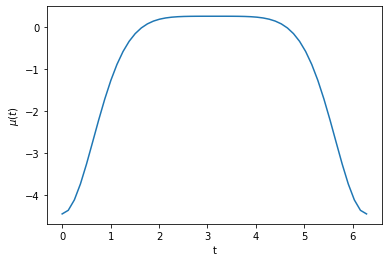

In [4]:
# plots mu vs t

t_values = gal.get_t_values(N)
plt.plot(t_values,mu)
plt.xlabel('t')
plt.ylabel('$\mu (t)$')

In [5]:
# next we solve for u from mu

# first obtain the kernel (dG/dn) from the above instance of the class
new_dgreens_dn = gal.dgreens_dn.subs({gal.x1:q, gal.x2: r})
new_dgreens_dn = sp.simplify(new_dgreens_dn)
new_dgreens_dn

0.159154943091895*(q*cos(t) + r*sin(t) - 1)/((q - cos(t))**2 + (r - sin(t))**2)

In [6]:
# next we solve for u with composite trapezoid rule in the next two cells

# define h and the input variable t
h = gal.h
t = gal.t

# define the kernel which can be evaluated at discrete values
lam_dgreens_dn = sp.lambdify(t,new_dgreens_dn)

In [7]:
# obtain the weights for composite trapezoid rule and then solve for u on the grid (u_lam solution that can be evaluated)
weights = gal.get_trap_weights(N)
u = 0
# do composite trapezoid rule
for i in range(0,N+1):
        u = u + (weights[i] * mu[i] * lam_dgreens_dn(h*i))

# create solution function u that can be evaluated at points in the domain
u_lam = sp.lambdify([q,r],u)

# define the true solution to compute error
true_soln = sp.lambdify([q,r],rhs)

# print a random test value to spot check accuracy
print(u_lam(0,0))
print(true_soln(0,0))

0.9999999999999979
1.0


In [8]:
# next we check the absolute error at sevaral points in the domain 

# define the number of random points to check, the array to store error, and compute the error at these points
npts = 30
error_circ = np.zeros(npts)
dnpts = 1/30
for i in range(0,npts):
    error_circ[i] = np.abs(  u_lam(i*dnpts*1, dnpts*0) - true_soln(i*dnpts*1,dnpts*0)   )

[2.10942375e-15 4.68929578e-05 1.00103136e-04 1.60112306e-04
 2.27431336e-04 3.02601738e-04 3.86197291e-04 4.78825742e-04
 5.81130592e-04 6.93792968e-04 8.17533583e-04 9.53114797e-04
 1.10134277e-03 1.26306974e-03 1.43919636e-03 1.63067421e-03
 1.83850840e-03 2.06376027e-03 2.30755033e-03 2.57106167e-03
 2.85554871e-03 3.16239779e-03 3.49366396e-03 3.85656853e-03
 4.29812279e-03 5.15075637e-03 8.64924481e-03 2.89300001e-02
 1.52903920e-01 1.00888985e+00]


Text(0, 0.5, 'absolute error')

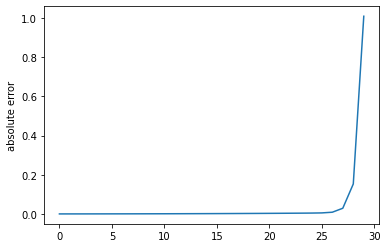

In [10]:
# display the error 
print(error_circ)
plt.plot(error_circ)
plt.ylabel('absolute error')

In [11]:
# this computes the error in the left hand side if that is desired through solving the boundary integral equation and 
# comparing to the right hand side
weights = gal.get_trap_weights(N)
mu_t = 0
for i in range(0,N+1):
        mu_t = mu_t + (weights[i] * mu[i] * (-1/ (4*np.pi)))

t_values = gal.get_t_values(N)
mu_s = np.zeros(N+1)
rhs_e = np.zeros(N+1)

for i in range(0,N+1):
    mu_s[i] = lam*mu[i] + mu_t
    rhs_e[i] = np.exp(np.cos(t_values[i]))*np.cos(np.sin(t_values[i]))
    
error_mu = np.zeros(N+1)
for i in range(0,N+1):
    error_mu[i] = np.abs( mu_s[i] - rhs_e[i] )

inferror_mu = np.linalg.norm(error_mu,np.inf)
print(inferror_mu)  

0.0071818187783225795


Text(0, 0.5, 'left-hand side')

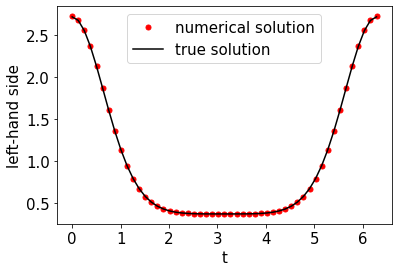

In [12]:
# this plots the numerical mu (left hand side) vs the right hand side (true solution)
plt.rcParams.update({'font.size': 15})
p1 = plt.plot(t_values, mu_s, 'ro',markersize = 5, label = 'numerical solution')
p2 = plt.plot(t_values, rhs_e, 'k-', label = 'true solution')
plt.legend()
plt.xlabel('t')
plt.ylabel('left-hand side')

In [3]:
# below runs the code for the ellipse case

q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
# define the right hand side
rhs = sp.exp(q)*sp.cos(r)

# define the number of grid points
N = 20

# beginning and ending points of boundary domain
a = 0
b = 2*np.pi

# lambda in the equation
lam = -0.5

# parameterization 
x1 = 2*sp.cos(q)
x2 = sp.sin(q)

# define an instance of the class, then construct greens functions, build the linear system, then solve for mu
gal_e = galerkin_bim(N, a, b, lam, x1, x2, rhs)
gal_e.construct_greens_function()
gal_e.build_linear_system()
mu_e = gal_e.solve_mu()


In [4]:
# print mu as a spot check
print(mu_e)

[-10.43218656  -9.02001644  -5.53980366  -2.33570366  -0.59933343
   0.08094214   0.3085708    0.41064431   0.515837     0.67896649
   0.7955658    0.67890554   0.5158574    0.4107471    0.30875562
   0.08122149  -0.59893254  -2.33514235  -5.53903068  -9.01914934
 -10.43210064]


Text(0, 0.5, '$\\mu (t)$')

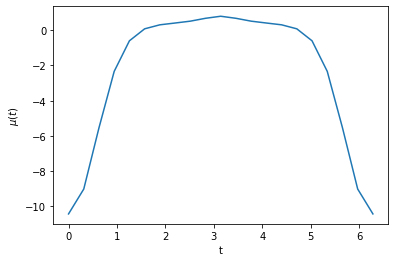

In [5]:
# plots mu vs t
t_values = gal_e.get_t_values(N)
plt.plot(t_values,mu_e)
plt.xlabel('t')
plt.ylabel('$\mu (t)$')

In [6]:
# next we solve for u from mu

# first obtain the kernel (dG/dn) from the above instance of the class
new_dgreens_dn_e = gal_e.dgreens_dn.subs({gal_e.x1:q, gal_e.x2: r})
new_dgreens_dn_e = sp.simplify(new_dgreens_dn_e)
new_dgreens_dn_e

(0.159154943091895*q*cos(t) + 0.318309886183791*r*sin(t) - 0.318309886183791)/(((q - 2*cos(t))**2 + (r - sin(t))**2)*sqrt(3*sin(t)**2 + 1))

In [7]:
# next we solve for u with composite trapezoid rule in the next two cells

# define h and the input variable t
h = gal_e.h
t = gal_e.t

# define the kernel which can be evaluated at discrete values
lam_dgreens_dn_e = sp.lambdify(t,new_dgreens_dn_e)

In [11]:
# obtain the weights for composite trapezoid rule and then solve for u on the grid (u_lam_e solution that can be evaluated)
weights = gal_e.get_trap_weights(N)
u_e = 0
# do composite trapezoid rule
for i in range(0,N+1):
        u_e = u_e + (weights[i] * mu_e[i] * lam_dgreens_dn_e(h*i))

# create solution function u that can be evaluated at points in the domain
u_lam_e = sp.lambdify([q,r],u_e)

# define the true solution to compute error
true_soln = sp.lambdify([q,r],rhs)

# print a random test value
print(u_lam_e(0,0))
print(true_soln(0,0))

0.9996579844825116
1.0


In [12]:
# next we evaluate u at sevaral points in the domain 

# define the number of random points to check and the array to store u at these points
# also define an array for absolute error to compare to right hand side
npts = 30
u_ellipse = np.zeros(npts)
error_ellipse = np.zeros(npts)
dnpts = 1/30
for i in range(0,npts):
    u_ellipse[i] = u_lam_e(i*dnpts*1, dnpts*0)
    error_ellipse[i] = np.abs(  u_lam_e(i*dnpts*1, dnpts*0) - true_soln(i*dnpts*1,dnpts*0)   )

[0.99965798 1.02616746 1.05346062 1.0815719  1.11053697 1.14039291
 1.17117823 1.20293302 1.23569912 1.26952027 1.30444231 1.3405134
 1.37778417 1.41630798 1.45614105 1.4973426  1.53997499 1.58410377
 1.62979767 1.67712864 1.72617182 1.77700557 1.82971154 1.88437488
 1.94108457 1.99993392 2.06102128 2.12445095 2.19033412 2.25878985]


Text(0, 0.5, 'u')

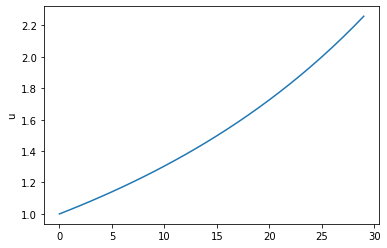

In [10]:
# display the values of u at the random points
print(u_ellipse)
plt.plot(u_ellipse)
plt.ylabel('u')

[3.42015517e-04 7.72765533e-03 1.54784828e-02 2.35990225e-02
 3.20938378e-02 4.09674990e-02 5.02245289e-02 5.98693243e-02
 6.99060545e-02 8.03385394e-02 9.11701111e-02 1.02403467e-01
 1.14040525e-01 1.26082283e-01 1.38528713e-01 1.51378673e-01
 1.64629871e-01 1.78278870e-01 1.92321131e-01 2.06751086e-01
 2.21562223e-01 2.36747140e-01 2.52297543e-01 2.68204133e-01
 2.84456358e-01 3.01041976e-01 3.17946448e-01 3.35152156e-01
 3.52637521e-01 3.70376105e-01]


Text(0, 0.5, 'absolute error')

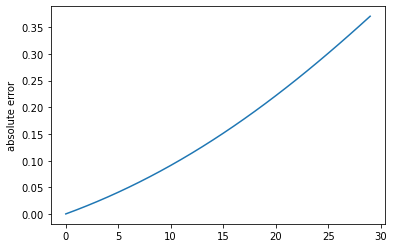

In [13]:
# display the error 
print(error_ellipse)
plt.plot(error_ellipse)
plt.ylabel('absolute error')